In [1]:
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

SEED = 42
torch.manual_seed(SEED)

# Custom loss function
def custom_loss(gamma, sigma, output, target):
    p = torch.rand(output.shape).to(device)
    
    def weight_form(alpha):
        return (p**alpha)/(p**alpha + (1-p)**alpha)**(1/alpha)
    
    agg_pi = weight_form(gamma) + weight_form(sigma)
    loss = (output - target)**2 * agg_pi
    mean_loss = torch.mean(loss)
    return mean_loss, loss

# Custom loss function
def ws_loss(output, target):
    loss = (output - target)**2
    mean_loss = torch.mean(loss)
    return mean_loss, loss

# Define neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model Parameters
gamma = 0.9
sigma = 0.95
    
# Set up data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transform),
    batch_size=64, shuffle=True, pin_memory=True)

# Instantiate neural network model and optimizer, and move them to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Train the model
model.train()
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss, _ = custom_loss(
            gamma, sigma, output, 
            nn.functional.one_hot(target, num_classes=10).float().to(device)
        )
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            
# Test the model and track losses of misclassified samples
# Configure logging
logging.basicConfig(filename='logs/MNIST_g{:.2f}_s{:.2f}_seed{:.0f}.txt'.format(gamma, sigma, SEED), level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

model.eval()
test_loss = 0
correct = 0
misclassified_losses = [] # list to store losses of misclassified samples
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss, sample_losses = ws_loss(output, nn.functional.one_hot(target, num_classes=10).float().to(device))
        test_loss += loss.item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        for i in range(len(target)):
            if pred[i] != target[i]:
                misclassified_losses.append(torch.mean(sample_losses[i]).item()) # add loss of misclassified sample to list

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.10f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # Log the output
    logging.info('Test set: Average loss: {:.10f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


C:\Users\surya\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch: 0 [0/60000 (0%)]	Loss: 0.137827
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.062522
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.051167
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.050564
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.047156
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.043858
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.043376
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.033331
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.036459
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.030406
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.028363
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.034966
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.029391
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.025445
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.030172
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.031374
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.027039
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.027098
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.032831
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.036942
Train Epoch:

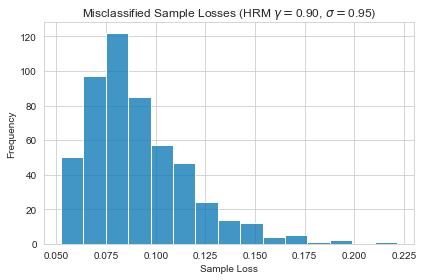

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("colorblind")

# Plot histogram of misclassified sample losses
plt.figure(figsize=(6, 4))
sns.histplot(misclassified_losses, kde=False, bins=15)
plt.xlabel("Sample Loss")
plt.ylabel("Frequency")
plt.title("Misclassified Sample Losses (HRM $\gamma = ${:.2f}, $\sigma = ${:.2f})".format(gamma, sigma))
# plt.xlim([0, 2]) # set the range of the x-axis
plt.tight_layout()
plt.savefig('Results/MNIST_g${:.2f}_s${:.2f}_seed{:.0f}.png'.format(gamma, sigma, SEED))  # save the figure as a PNG file
plt.show()
